In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ismetsemedov/transactions")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ismetsemedov/transactions/versions/1


In [2]:
!ls /root/.cache/kagglehub/datasets/ismetsemedov/transactions/versions/1 

synthetic_fraud_data.csv


## Import Dependencies

In [3]:
import pandas as pd
import ast
from xgboost import XGBClassifier
from xgbtune import tune_xgb_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

## Load Dataset

In [4]:
df = pd.read_csv("/root/.cache/kagglehub/datasets/ismetsemedov/transactions/versions/1/synthetic_fraud_data.csv")

df.head()

,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,...,device,channel,device_fingerprint,ip_address,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud
0,TX_a0ad2a2a,CUST_72886,6646734767813109,2024-09-30 00:00:01.034820+00:00,Restaurant,fast_food,Taco Bell,294.87,GBP,UK,...,iOS App,mobile,e8e6160445c935fd0001501e4cbac8bc,197.153.60.199,0,False,0,False,"{'num_transactions': 1197, 'total_amount': 334...",False
1,TX_3599c101,CUST_70474,376800864692727,2024-09-30 00:00:01.764464+00:00,Entertainment,gaming,Steam,3368.97,BRL,Brazil,...,Edge,web,a73043a57091e775af37f252b3a32af9,208.123.221.203,1,True,0,False,"{'num_transactions': 509, 'total_amount': 2011...",True
2,TX_a9461c6d,CUST_10715,5251909460951913,2024-09-30 00:00:02.273762+00:00,Grocery,physical,Whole Foods,102582.38,JPY,Japan,...,Firefox,web,218864e94ceaa41577d216b149722261,10.194.159.204,0,False,0,False,"{'num_transactions': 332, 'total_amount': 3916...",False
3,TX_7be21fc4,CUST_16193,376079286931183,2024-09-30 00:00:02.297466+00:00,Gas,major,Exxon,630.60,AUD,Australia,...,iOS App,mobile,70423fa3a1e74d01203cf93b51b9631d,17.230.177.225,0,False,0,False,"{'num_transactions': 764, 'total_amount': 2201...",False
4,TX_150f490b,CUST_87572,6172948052178810,2024-09-30 00:00:02.544063+00:00,Healthcare,medical,Medical Center,724949.27,NGN,Nigeria,...,Chrome,web,9880776c7b6038f2af86bd4e18a1b1a4,136.241.219.151,1,False,0,False,"{'num_transactions': 218, 'total_amount': 4827...",True


### Dataset Size

In [5]:
df.size

179610384

## Sampling

In [6]:
df_all = df.copy()
df = df.sample(n=1000000, random_state=42).reset_index(drop=True)

In [7]:
df.columns

Index(['transaction_id', 'customer_id', 'card_number', 'timestamp',
       'merchant_category', 'merchant_type', 'merchant', 'amount', 'currency',
       'country', 'city', 'city_size', 'card_type', 'card_present', 'device',
       'channel', 'device_fingerprint', 'ip_address', 'distance_from_home',
       'high_risk_merchant', 'transaction_hour', 'weekend_transaction',
       'velocity_last_hour', 'is_fraud'],
      dtype='object')

In [8]:
ex = ast.literal_eval(df['velocity_last_hour'][0])
ex

{'num_transactions': 410,
 'total_amount': 9771834.612817284,
 'unique_merchants': 103,
 'unique_countries': 12,
 'max_single_amount': 2076391.2394741082}

### Dividing velocity_last_hour

In [9]:
velocity_df = df['velocity_last_hour'].apply(ast.literal_eval).apply(pd.Series)

# Concatenate the new columns to the original dataframe
df = pd.concat([df, velocity_df], axis=1)

df.head()

,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,...,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount
0,TX_8ab03451,CUST_45506,4276387718511132,2024-10-02 07:37:53.648473+00:00,Restaurant,casual,Red Lobster,544.43,BRL,Brazil,...,False,7,False,"{'num_transactions': 410, 'total_amount': 9771...",False,410.0,9.771835e+06,103.0,12.0,2.076391e+06
1,TX_9b278186,CUST_60434,6372131493335111,2024-10-08 01:20:04.635733+00:00,Education,online,Skillshare,1.46,CAD,Canada,...,False,1,False,"{'num_transactions': 1203, 'total_amount': 314...",True,1203.0,3.149272e+07,105.0,12.0,2.426354e+06
2,TX_7f80b3c4,CUST_47739,6032951922681435,2024-10-28 16:04:39.625391+00:00,Entertainment,streaming,Disney+,158.73,CAD,Canada,...,True,16,False,"{'num_transactions': 100, 'total_amount': 3168...",True,100.0,3.168371e+06,62.0,11.0,8.079625e+05
3,TX_7202f8a2,CUST_77691,5021869140628407,2024-10-03 15:06:36.624159+00:00,Restaurant,casual,TGI Fridays,1074.57,BRL,Brazil,...,False,15,False,"{'num_transactions': 335, 'total_amount': 6421...",False,335.0,6.421794e+06,99.0,12.0,1.163648e+06
4,TX_75f107d6,CUST_86097,5070103713053862,2024-10-19 10:30:45.169341+00:00,Entertainment,streaming,HBO Max,1399.64,MXN,Mexico,...,True,10,True,"{'num_transactions': 426, 'total_amount': 1433...",False,426.0,1.433802e+07,100.0,12.0,1.915303e+06


## Encoding columns

In [10]:
le = LabelEncoder()

In [11]:
columns_to_encode = ['merchant_category', 'merchant_type', 'merchant', 'currency', 'device', 'country',  'city', 'city_size', 'card_type', 'card_present', 'channel', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']
df[columns_to_encode] = df[columns_to_encode].apply(lambda col: le.fit_transform(col))

In [12]:
df.head()

,transaction_id,customer_id,card_number,timestamp,merchant_category,merchant_type,merchant,amount,currency,country,...,high_risk_merchant,transaction_hour,weekend_transaction,velocity_last_hour,is_fraud,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount
0,TX_8ab03451,CUST_45506,4276387718511132,2024-10-02 07:37:53.648473+00:00,5,2,69,544.43,1,1,...,0,7,0,"{'num_transactions': 410, 'total_amount': 9771...",0,410.0,9.771835e+06,103.0,12.0,2.076391e+06
1,TX_9b278186,CUST_60434,6372131493335111,2024-10-08 01:20:04.635733+00:00,0,10,77,1.46,2,2,...,0,1,0,"{'num_transactions': 1203, 'total_amount': 314...",1,1203.0,3.149272e+07,105.0,12.0,2.426354e+06
2,TX_7f80b3c4,CUST_47739,6032951922681435,2024-10-28 16:04:39.625391+00:00,1,14,24,158.73,2,2,...,1,16,0,"{'num_transactions': 100, 'total_amount': 3168...",1,100.0,3.168371e+06,62.0,11.0,8.079625e+05
3,TX_7202f8a2,CUST_77691,5021869140628407,2024-10-03 15:06:36.624159+00:00,5,2,83,1074.57,1,1,...,0,15,0,"{'num_transactions': 335, 'total_amount': 6421...",0,335.0,6.421794e+06,99.0,12.0,1.163648e+06
4,TX_75f107d6,CUST_86097,5070103713053862,2024-10-19 10:30:45.169341+00:00,1,14,34,1399.64,6,6,...,1,10,1,"{'num_transactions': 426, 'total_amount': 1433...",0,426.0,1.433802e+07,100.0,12.0,1.915303e+06


## Dropping unnecessary columns

In [13]:
df.drop(['velocity_last_hour', 'device_fingerprint', 'card_number', 'customer_id', 'transaction_id', 'timestamp', 'ip_address'], axis=1, inplace=True)
df.head()

,merchant_category,merchant_type,merchant,amount,currency,country,city,city_size,card_type,card_present,...,distance_from_home,high_risk_merchant,transaction_hour,weekend_transaction,is_fraud,num_transactions,total_amount,unique_merchants,unique_countries,max_single_amount
0,5,2,69,544.43,1,1,10,1,1,0,...,0,0,7,0,0,410.0,9.771835e+06,103.0,12.0,2.076391e+06
1,0,10,77,1.46,2,2,10,1,0,1,...,1,0,1,0,1,1203.0,3.149272e+07,105.0,12.0,2.426354e+06
2,1,14,24,158.73,2,2,10,1,1,1,...,0,1,16,0,1,100.0,3.168371e+06,62.0,11.0,8.079625e+05
3,5,2,83,1074.57,1,1,10,1,0,0,...,0,0,15,0,0,335.0,6.421794e+06,99.0,12.0,1.163648e+06
4,1,14,34,1399.64,6,6,10,1,1,0,...,0,1,10,1,0,426.0,1.433802e+07,100.0,12.0,1.915303e+06


## Train test split

In [14]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

#### Shrink dimensionality using PCA

In [ ]:
# Initialize PCA with 5 components
pca = PCA(n_components=5)

# Fit and transform the data
X_pca = pca.fit_transform(X)

In [16]:


X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


# Model

In [17]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'error',
}

params, count = tune_xgb_model(params, X_train, y_train, X_val, y_val)


# Create the XGBClassifier
xgb = XGBClassifier(**params)


tuning pass 0...
computing best round...
best round: 130
tuning max_depth and min_child_weight ...
best loss: 0.17739
best max_depth: 8
best min_child_weight: 3
tuning gamma ...
best loss: 0.17739
best gamma: 0.0
re-computing best round...
best round: 96
tuning subsample and colsample_bytree ...
best loss: 0.17729
best subsample: 1.0
best colsample_bytree: 1.0
fine tuning subsample and colsample_bytree ...
best loss: 0.17729
best subsample: 1.0
best colsample_bytree: 1.0
tuning alpha and lambda ...
best loss: 0.17729
best alpha: 0
best lambda: 1
tuning seed ...
best loss: 0.17729
best seed: 0
{'objective': 'binary:logistic', 'eval_metric': 'error', 'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.0, 'subsample': 1.0, 'colsample_bytree': 1.0, 'alpha': 0, 'lambda': 1, 'seed': 0}
tuning pass 1...
computing best round...
best round: 96
tuning max_depth and min_child_weight ...
best loss: 0.17729
best max_depth: 8
best min_child_weight: 3
tuning gamma ...
best loss: 0.17729
best gamma: 0.0

In [18]:
xgb.fit(X_train, y_train)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1, learning_rate=None,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [19]:
y_pred = xgb.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.82162


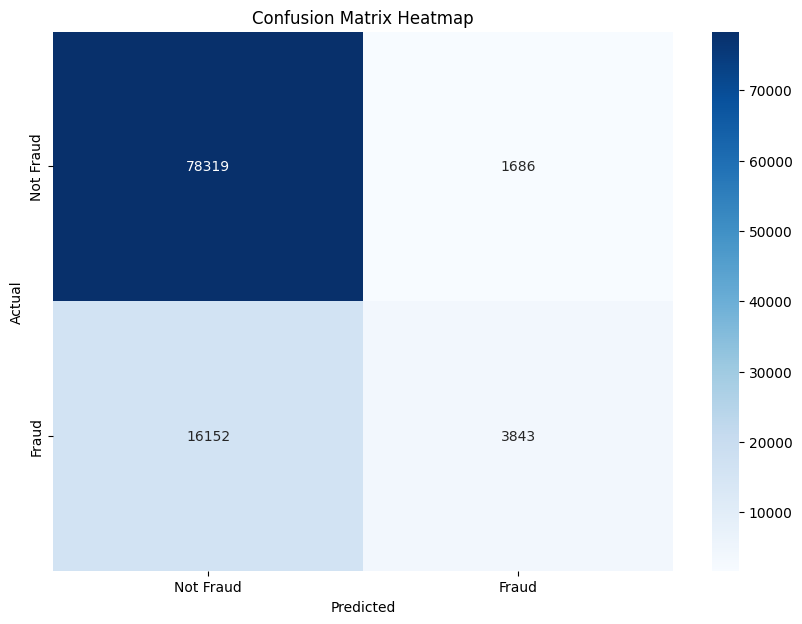

In [21]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [22]:
#Check with other part of df
df = df_all.sample(n=100000, random_state=42).reset_index(drop=True)
# Separating velocity_last_hour column
velocity_df = df['velocity_last_hour'].apply(ast.literal_eval).apply(pd.Series)
# Concatenate the new columns to the original dataframe
df = pd.concat([df, velocity_df], axis=1)
# Encoding the categorical columns
columns_to_encode = ['merchant_category', 'merchant_type', 'merchant', 'currency', 'device', 'country',  'city', 'city_size', 'card_type', 'card_present', 'channel', 'high_risk_merchant', 'weekend_transaction', 'is_fraud']
df[columns_to_encode] = df[columns_to_encode].apply(lambda col: le.transform(col))
# Drop unnecessary columns
df.drop(['velocity_last_hour', 'device_fingerprint', 'card_number', 'customer_id', 'transaction_id', 'timestamp', 'ip_address'], axis=1, inplace=True)
# Split the data into X and y
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']
X_pca = pca.transform(X)

# Predict the target variable
y_pred = xgb.predict(X_pca)
# Calculate the accuracy
accuracy = accuracy_score(y, y_pred)
# Print the accuracy
print("Accuracy: ", accuracy)

Accuracy:  0.82864


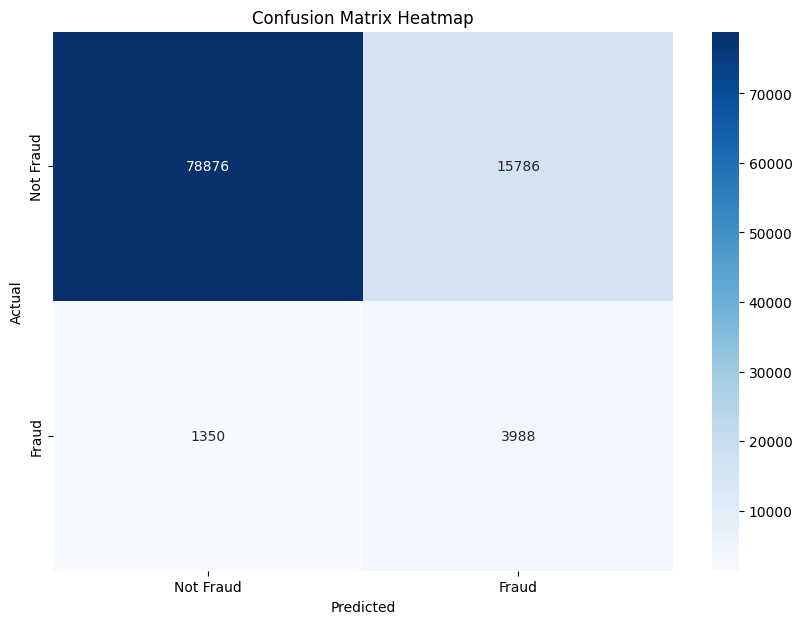

In [24]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_pred, y)

# Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Conclusion

This notebook demonstrates the process of detecting fraudulent transactions using a machine learning model. We started by downloading and exploring the dataset, followed by preprocessing steps such as encoding categorical variables and handling the `velocity_last_hour` column. We then reduced the dimensionality of the data using PCA and split it into training, validation, and test sets.

We tuned the hyperparameters of an XGBoost classifier and trained the model on the training set. The model's performance was evaluated using accuracy and a confusion matrix. The final model achieved an accuracy of 82.86% on the test set, indicating a good ability to distinguish between fraudulent and non-fraudulent transactions.

This workflow provides a comprehensive approach to building and evaluating a fraud detection model, highlighting the importance of data preprocessing, feature engineering, and model tuning.